In [1]:
import pandas as pd
from pprint import pprint
import numpy as np
import plotly.express as px
import yfinance as yf
from tqdm import tqdm
import pandas_ta as ta
import seaborn as sns
import plotly.graph_objects as go
import featuretools as ft
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, ConfusionMatrixDisplay

In [2]:
pd.DataFrame({'A': [1, 2, 3]}).to_csv('teste.csv')

In [3]:
warnings.filterwarnings('ignore')

# Funções e classes

In [4]:
def get_price_acction(acao_cod, start, end, freq='1d'):
    '''
    retorna o histórico de precos de uma acao.
    inputs:
        acao_cod: str  condigo da acao listada na Bovespa
        start: str data inicial 
        end: str data final
        interval: str frequencia: (1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo)
    '''
    tick = yf.Ticker(acao_cod+'.SA' if acao_cod != 'BVSP' else '^BVSP')
    df_aux = tick.history(
        start=start,
        end=end,
        interval=freq,
        actions=False
    )
    # variaacoes
    df_aux['acao'] = acao_cod.split('.')[0]
    return df_aux


def get_index(df_aux):
    '''
    cria features
    '''
    df_aux.ta.strategy('candles')
    df_aux.ta.strategy('momentum')
    df_aux.ta.strategy('performance')
    df_aux.ta.strategy('statistics')
    df_aux.ta.strategy('trend')
    df_aux.ta.strategy('volatility')
    df_aux.ta.strategy('volume')
    return df_aux


def signal_method(df, price='Close', window=11):
    '''
    marca o sinal de compra (1), venda (2) e mantem acao a partir do preco de referencia. metodo sugerido por: 
    Sezer, O. B., & Ozbayoglu, A. M. (2018). Algorithmic financial trading with deep
    convolutional neural networks: Time series to image conversion approach. Applied
    Soft Computing, 70, 525–538. 

    inputs:
        df: pd.DataFrame base de dados com o preco de referencia de cada acao
        price: str  Preco de referencia. default Close
        window: int tamanho da janela de tempo. default int
    '''
    window_min = df[price].rolling(window, center=True).min()
    window_max = df[price].rolling(window, center=True).max()
    # marcacao
    signal = np.where(
        df[price] == window_min,
        1,
        np.where(
            df[price] == window_max, 2, 0
        )
    )
    return signal

# Construção da base

## Downloading Historico de preco

Dados de 2015-01-01 a 2024-06-30

In [5]:
acoes = [
    'OIBR3', 'COGN3', 'PETR4', 'VVAR3', 'CIEL3', 'BBDC4', 'IRBR3', 'MGLU3', 'VALE3', 'BEEF3', 'ITUB4', 'JBSS3',
    'MRFG3', 'ITSA4', 'BRFS3', 'ABEV3', 'BRML3', 'POMO4', 'SUZB3', 'EMBR3', 'USIM5', 'CSNA3', 'BBAS3', 'RAIL3',
    'CVCB3', 'GOAU4', 'GOLL4',
    'AZUL4', 'PRIO3', 'PETR3', 'GGBR4', 'B3SA3', 'STBP3', 'LAME4', 'CMIG4', 'AERI3', 'HAPV3', 'TOTS3', 'LREN3',
    'CCRO3', 'OIBR4', 'JHSF3', 'BRDT3', 'KLBN11', 'BBDC3', 'EQTL3', 'GNDI3', 'MULT3', 'CYRE3', 'TIMS3', 'RENT3',
    'RAPT4', 'QUAL3', 'ELET3', 'CESP6', 'VIVT3', 'HGTX3', 'UGPA3', 'BIDI4', 'WEGE3', 'SBSP3', 'PETZ3', 'MRVE3', 'NTCO3',
    'GMAT3', 'BTOW3', 'CRFB3', 'ODPV3', 'EVEN3', 'BPAC11', 'BMGB4', 'BKBR3', 'ECOR3', 'SULA11', 'MOVI3', 'RADL3',
    'YDUQ3', 'BRKM5', 'BBSE3', 'CSAN3', 'DTEX3', 'RLOG3', 'SANB11', 'SAPR4', 'BPAN4', 'RDOR3', 'ELET6', 'BOAS3', 'MDIA3',
    'TAEE11', 'ENAT3', 'SMLS3', 'CPFE3', 'ENBR3', 'IGTA3', 'LWSA3', 'LCAM3', 'CURY3', 'KLBN4', 'CSMG3', 'CAML3', 'LAME3',
    'SLCE3', 'BRSR6', 'GRND3', 'EZTC3', 'BRPR3', 'SAPR11', 'BRAP4', 'FLRY3', 'MYPK3', 'LIGT3', 'EGIE3', 'ALSO3',
    'NEOE3', 'HBSA3', 'HYPE3', 'TIET11', 'LJQQ3', 'CEAB3', 'TUPY3', 'ALPA4', 'TRPL4', 'ABCB4', 'ENEV3', 'TEND3',
    'SOMA3', 'CNTO3', 'SMTO3', 'ALUP11', 'ENJU3', 'PNVL3', 'TRIS3', 'SEQL3', 'BIDI3', 'ENGI11', 'PARD3', 'ANIM3',
    'GUAR3', 'CPLE6', 'VIVA3', 'UNIP6', 'LINX3', 'PSSA3', 'PCAR3', 'PGMN3', 'CCPR3', 'ARZZ3', 'SIMH3', 'TIET4',
    'CMIG3', 'POMO3', 'USIM3', 'ITUB3', 'OMGE3', 'AMBP3', 'KLBN3', 'LOGG3', 'JPSA3', 'TAEE4', 'LEVE3', 'RRRP3',
    'TIET3', 'FRAS3', 'CPLE3',  # 'BVSP'
]

In [6]:
df = pd.DataFrame()
for acao in tqdm(acoes):
    try:
        df_price = get_price_acction(
            acao, start='2015-06-01', end='2024-06-30')
        df_price['acao'] = acao

        df = pd.concat([df, df_price])
    except:
        print(f'Falha para download de acao {acao}')

100%|██████████| 165/165 [02:11<00:00,  1.25it/s]


In [7]:
# acoes na base
df['acao'].unique().shape

(134,)

In [8]:
df.head()

,Open,High,Low,Close,Volume,acao,Adj Close
Date,,,,,,,
2015-06-01 00:00:00-03:00,526.135864,538.822876,478.373199,487.328705,9327.0,OIBR3,NaN
2015-06-02 00:00:00-03:00,501.508270,526.882202,500.015686,514.195251,20005.0,OIBR3,NaN
2015-06-03 00:00:00-03:00,521.658142,534.345093,503.000854,505.239716,9974.0,OIBR3,NaN
2015-06-05 00:00:00-03:00,505.239716,508.971161,487.328705,491.060181,2795.0,OIBR3,NaN
2015-06-08 00:00:00-03:00,485.836121,493.299042,450.760406,458.969604,19162.0,OIBR3,NaN


## selecionando acoes

In [9]:
df = df.reset_index()
df_acoes = pd.pivot_table(
    data=df,
    values='Close',
    index='Date',
    columns='acao'
)

In [10]:
df_acoes.head()

acao,ABCB4,ABEV3,AERI3,ALPA4,ALUP11,AMBP3,ANIM3,ARZZ3,AZUL4,B3SA3,...,TUPY3,UGPA3,UNIP6,USIM3,USIM5,VALE3,VIVA3,VIVT3,WEGE3,YDUQ3
Date,,,,,,,,,,,,,,,,,,,,,
2015-06-01 00:00:00-03:00,4.482533,13.580485,NaN,6.692925,9.588662,NaN,6.769010,19.458183,NaN,2.726002,...,11.737517,12.636670,1.186321,12.707681,3.956676,11.734487,NaN,21.118940,5.665924,13.234107
2015-06-02 00:00:00-03:00,4.607920,13.617188,NaN,6.611962,9.538018,NaN,6.814093,20.069731,NaN,2.782500,...,11.364359,12.778492,1.171970,12.587798,4.042861,12.501560,NaN,20.807394,5.807408,13.456904
2015-06-03 00:00:00-03:00,4.506045,13.521756,NaN,6.652443,9.566153,NaN,6.762569,19.855295,NaN,2.770729,...,11.011553,12.654855,1.181538,12.707681,3.948841,12.232207,NaN,20.918657,5.807408,13.122708
2015-06-05 00:00:00-03:00,4.506045,13.727299,NaN,6.584974,9.481745,NaN,6.727147,19.617029,NaN,2.763668,...,11.500052,12.654855,1.167187,11.836527,3.846986,12.062398,NaN,20.584843,5.879794,13.590580
2015-06-08 00:00:00-03:00,4.462943,13.551121,NaN,6.456783,9.312932,NaN,7.052394,19.394655,NaN,2.716586,...,11.228663,12.554854,1.162404,11.796566,3.737296,11.769622,NaN,20.028507,5.866633,13.375212


In [11]:
df.shape

(271722, 8)

In [12]:
# percentual de acoes com nulos
df_nulos = (
    df_acoes.isnull().sum()/df_acoes.shape[0]
)
df_nulos[df_nulos > 0].shape[0]/df_nulos.shape[0]

0.22388059701492538

In [13]:
# acoes com nulos
acoes_nulos = df_nulos[df_nulos > 0].index.to_list()
print(acoes_nulos)

['AERI3', 'AMBP3', 'AZUL4', 'BMGB4', 'BPAC11', 'CAML3', 'CEAB3', 'CRFB3', 'CURY3', 'ENJU3', 'GMAT3', 'HAPV3', 'HBSA3', 'IRBR3', 'LJQQ3', 'LOGG3', 'LWSA3', 'MOVI3', 'NEOE3', 'NTCO3', 'PETZ3', 'PGMN3', 'RDOR3', 'RRRP3', 'SAPR11', 'SEQL3', 'SIMH3', 'SOMA3', 'TAEE4', 'VIVA3']


In [14]:
# removendo acoes com nulos
acoes_selecionadas = [
    i for i in df_nulos.index.to_list() if i not in acoes_nulos]

In [15]:
len(acoes_selecionadas), len(acoes_nulos), df_nulos.shape[0]

(104, 30, 134)

In [16]:
# indentificando acoes correlacionadas
df_acoes = df_acoes[acoes_selecionadas]

# diferenca acumuladas no periodo
df_acoes_norm = df_acoes.diff().cumsum()

In [17]:
df_corr = (
    df_acoes_norm
    .corr()
    .stack()
    .to_frame()
    .rename(columns={0: 'corr'})
)
df_corr.index.names = ['acao1', 'acao2']
df_corr = df_corr.reset_index().sort_values('corr').drop_duplicates()
df_corr = df_corr[df_corr['corr'] != 0]

In [18]:
df_corr.head()

,acao1,acao2,corr
3971,ENGI11,CIEL3,-0.899973
2014,CIEL3,ENGI11,-0.899973
8547,RENT3,CIEL3,-0.899015
2058,CIEL3,RENT3,-0.899015
643,B3SA3,CIEL3,-0.889783


In [19]:
df_corr.describe()

,corr
count,10816.000000
mean,0.380910
std,0.444955
min,-0.899973
25%,0.123269
50%,0.473334
75%,0.750559
max,1.000000


## isolando grupos de acoes mais próximos entre si

In [20]:
from sklearn.cluster import KMeans

# Suponha que você já tenha o DataFrame df_acoes_norm
# (onde cada coluna representa o preço de uma ação ao longo do tempo)

# Calcula a matriz de correlação
df_corr = df_acoes_norm.corr()

# Usando K-means para agrupar as ações
n_clusters = 3  # Defina o número de grupos desejado
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(df_corr)

# Adiciona os rótulos dos grupos ao DataFrame original
df_corr['label'] = kmeans.labels_

In [21]:
grupos = {}
for grupo in df_corr['label'].unique():
    grupos['grupo_'+str(grupo)] = df_corr[df_corr['label']
                                          == grupo].index.to_list()

In [22]:
df_corr_grupos = pd.DataFrame()

for grupo in grupos.keys():
    df_corr_grupo = (
        df_acoes_norm[grupos[grupo]]
        .corr()
        .stack()
        .to_frame()
        .rename(columns={0: 'corr'})
    )
    df_corr_grupo.index.names = ['acao1', 'acao2']
    df_corr_grupo = df_corr_grupo.reset_index().sort_values('corr').drop_duplicates()
    df_corr_grupo = df_corr_grupo[df_corr_grupo['corr'] != 1]
    df_corr_grupos[grupo] = df_corr_grupo.describe()
    print(f'{grupo} - {len(grupos[grupo])} acoes')
df_corr_grupos.index = df_corr_grupo.describe().index

grupo_1 - 66 acoes
grupo_2 - 9 acoes
grupo_0 - 29 acoes


In [23]:
df_corr_grupos

,grupo_1,grupo_2,grupo_0
count,4290.000000,72.000000,812.000000
mean,0.738550,0.441276,0.446685
std,0.156210,0.289307,0.300403
min,0.010749,-0.289709,-0.350574
25%,0.660212,0.242103,0.212391
50%,0.772591,0.500029,0.485962
75%,0.853570,0.656091,0.692966
max,0.997830,0.969897,0.973616


In [24]:
df_acoes_norm[grupos['grupo_1']].corr()

acao,ABCB4,ALUP11,ARZZ3,B3SA3,BBAS3,BBSE3,BPAN4,BRAP4,CMIG3,CMIG4,...,TIMS3,TOTS3,TRPL4,TUPY3,UGPA3,UNIP6,USIM5,VALE3,VIVT3,WEGE3
acao,,,,,,,,,,,,,,,,,,,,,
ABCB4,1.000000,0.904427,0.688560,0.619760,0.942700,0.866307,0.498551,0.765803,0.829041,0.879611,...,0.888067,0.664142,0.840088,0.838795,0.583271,0.747776,0.460055,0.713580,0.841779,0.683698
ALUP11,0.904427,1.000000,0.795839,0.805174,0.890917,0.886836,0.693381,0.876104,0.913316,0.948109,...,0.887380,0.855727,0.960739,0.876767,0.445768,0.834347,0.547815,0.838114,0.928817,0.863421
ARZZ3,0.688560,0.795839,1.000000,0.800742,0.597463,0.565816,0.764007,0.883564,0.756771,0.737092,...,0.656072,0.868554,0.855089,0.799810,0.157330,0.884680,0.784284,0.913470,0.777915,0.826707
B3SA3,0.619760,0.805174,0.800742,1.000000,0.615275,0.603441,0.800152,0.730968,0.607366,0.647017,...,0.718101,0.849183,0.842125,0.690871,0.010749,0.634761,0.694156,0.781395,0.819656,0.828479
BBAS3,0.942700,0.890917,0.597463,0.615275,1.000000,0.892790,0.454073,0.683200,0.810777,0.874030,...,0.883406,0.598139,0.801354,0.812653,0.542064,0.652916,0.390066,0.628951,0.815332,0.622470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UNIP6,0.747776,0.834347,0.884680,0.634761,0.652916,0.686311,0.639518,0.959500,0.910245,0.878244,...,0.687299,0.851317,0.881054,0.860611,0.394694,1.000000,0.594222,0.921397,0.802727,0.844110
USIM5,0.460055,0.547815,0.784284,0.694156,0.390066,0.228952,0.796252,0.669551,0.401240,0.451638,...,0.528217,0.705219,0.672459,0.532644,0.066506,0.594222,1.000000,0.787729,0.625048,0.646823
VALE3,0.713580,0.838114,0.913470,0.781395,0.628951,0.639058,0.777965,0.973417,0.808678,0.814155,...,0.718651,0.904163,0.910881,0.828945,0.271924,0.921397,0.787729,1.000000,0.827217,0.905283


In [25]:
df_corr_selecionadas = df_acoes_norm[grupos['grupo_1']].corr()

<Axes: xlabel='acao', ylabel='acao'>

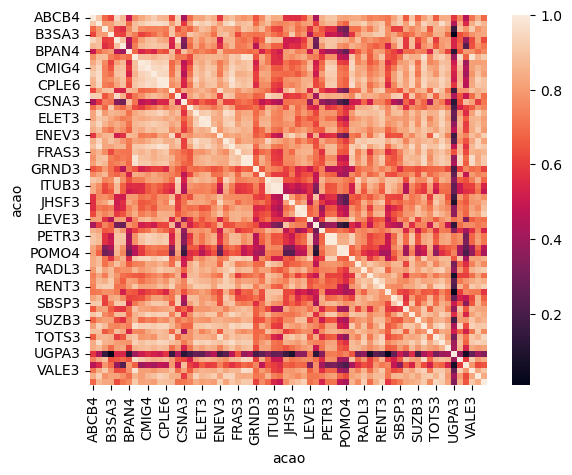

In [26]:
sns.heatmap(df_corr_selecionadas)

In [27]:
#
df_corr_selecionadas.describe().T.sort_values('mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
acao,,,,,,,,
EQTL3,66.0,0.848018,0.104195,0.471460,0.815867,0.874373,0.916044,1.0
TRPL4,66.0,0.843582,0.103963,0.395960,0.801379,0.857393,0.920229,1.0
ALUP11,66.0,0.840289,0.107705,0.445768,0.802940,0.870128,0.913171,1.0
CPLE3,66.0,0.826070,0.117226,0.481233,0.782098,0.853915,0.902425,1.0
ENGI11,66.0,0.821614,0.114131,0.240743,0.772695,0.841563,0.898613,1.0
...,...,...,...,...,...,...,...,...
MRFG3,66.0,0.591732,0.187020,0.112963,0.482972,0.621459,0.731805,1.0
CSNA3,66.0,0.588056,0.175143,0.124199,0.469901,0.606360,0.714955,1.0
USIM5,66.0,0.581032,0.171992,0.066506,0.479363,0.611254,0.689725,1.0


In [28]:
removida = 'UGPA3'
acoes_selecionadas = [i for i in grupos['grupo_1'] if i != removida]

In [29]:
len(acoes_selecionadas)

65

# Criando features

In [30]:
# filtrando acoes selecionadas
df = df[df['acao'].isin(acoes_selecionadas)]

In [31]:
df_final = pd.DataFrame()
for acao in tqdm(acoes_selecionadas):
    # isolando historico da acao
    df_aux = df[df['acao'] == acao].reset_index(drop=True)
    # criando features
    df_aux = get_index(df_aux)
    # criando sinal
    df_aux['signal'] = signal_method(df_aux)

    df_aux = df_aux.reset_index()
    #
    df_final = pd.concat([df_final, df_aux])

3it [00:01,  2.91it/s][00:00<?, ?it/s]
39it [00:02, 18.55it/s]
2it [00:00,  2.42it/s]
10it [00:00, 11.61it/s]
14it [00:01, 12.21it/s]
14it [00:00, 15.64it/s]
14it [00:00, 15.22it/s]
3it [00:01,  2.93it/s][00:08<08:51,  8.30s/it]
39it [00:02, 18.36it/s]
2it [00:00,  2.43it/s]
10it [00:00, 11.50it/s]
14it [00:01, 12.33it/s]
14it [00:00, 15.88it/s]
14it [00:00, 16.09it/s]
3it [00:01,  2.99it/s][00:16<08:41,  8.28s/it]
39it [00:02, 18.69it/s]
2it [00:00,  2.41it/s]
10it [00:00, 11.63it/s]
14it [00:01, 12.05it/s]
14it [00:00, 15.95it/s]
14it [00:00, 16.15it/s]
3it [00:01,  2.95it/s][00:24<08:31,  8.25s/it]
39it [00:02, 18.78it/s]
2it [00:00,  2.40it/s]
10it [00:00, 11.44it/s]
14it [00:01, 12.24it/s]
14it [00:00, 15.62it/s]
14it [00:00, 16.36it/s]
3it [00:01,  2.95it/s][00:33<08:22,  8.24s/it]
39it [00:02, 18.69it/s]
2it [00:00,  2.43it/s]
10it [00:00, 11.51it/s]
14it [00:01, 12.20it/s]
14it [00:00, 16.01it/s]
14it [00:00, 16.31it/s]
3it [00:01,  2.94it/s][00:41<08:13,  8.23s/it]
39it [00:02

# Pós tratamento

In [32]:
df_final.shape

(146835, 185)

In [33]:
df_final['signal'].value_counts()

signal
0    126808
1     10465
2      9562
Name: count, dtype: int64

## Removendo features com muitos nulos

In [34]:
df_null = df_final.isnull().sum()/df_final.shape[0]

In [35]:
df_null.sort_values(ascending=False).head(10)

Adj Close                      1.000000
PSARs_0.02_0.2                 0.526462
QQEl_14_5_4.236                0.506678
QQEs_14_5_4.236                0.506208
PSARl_0.02_0.2                 0.473981
EOM_14_100000000               0.067995
KVOs_34_55_13                  0.029216
KVO_34_55_13                   0.023904
KSTs_9                         0.023019
KST_10_15_20_30_10_10_10_15    0.019478
dtype: float64

In [36]:
features_removidas_nulls = df_null.loc[df_null > 0.05].index.to_list()
features_removidas_nulls

['Adj Close',
 'QQEl_14_5_4.236',
 'QQEs_14_5_4.236',
 'PSARl_0.02_0.2',
 'PSARs_0.02_0.2',
 'EOM_14_100000000']

In [37]:
df_final.drop(features_removidas_nulls, axis=1, inplace=True)

In [38]:
(df_final.isnull().sum()/df_final.shape[0]).sort_values(ascending=False)

KVOs_34_55_13                  0.029216
KVO_34_55_13                   0.023904
KSTs_9                         0.023019
KST_10_15_20_30_10_10_10_15    0.019478
low_Z_30_1                     0.018088
                                 ...   
TOS_STDEVALL_LR                0.000000
Date                           0.000000
STCstoch_10_12_26_0.5          0.000000
STC_10_12_26_0.5               0.000000
signal                         0.000000
Length: 179, dtype: float64

In [39]:
df_final.dropna(inplace=True)

In [40]:
df_final.shape

(141036, 179)

## removendo features correlacionadas

In [41]:
df_final = ft.selection.remove_highly_correlated_features(
    df_final, features_to_keep=[
        'index', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'acao'])

In [42]:
df_final.shape

(141036, 114)

In [43]:
df_final.columns

Index(['index', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'acao',
       'CDL_DOJI_10_0.1', 'CDL_INSIDE',
       ...
       'EFI_13', 'KVO_34_55_13', 'KVOs_34_55_13', 'MFI_14', 'NVI_1', 'PVI_1',
       'PVOL', 'PVR', 'PVT', 'signal'],
      dtype='object', length=114)

# Criando labels

A partir do sinal se cria uma lag 1 a 3 dias

In [44]:
df_final['label_l1'] = 0
df_final['label_l2'] = 0
df_final['label_l3'] = 0
for acao in acoes_selecionadas:
    df_final.loc[df_final['acao'] == acao, 'label_l1'] = df_final.loc[df_final['acao']
                                                                      == acao, 'signal'].shift(-1)
    df_final.loc[df_final['acao'] == acao, 'label_l2'] = df_final.loc[df_final['acao']
                                                                      == acao, 'signal'].shift(-2)
    df_final.loc[df_final['acao'] == acao, 'label_l3'] = df_final.loc[df_final['acao']
                                                                      == acao, 'signal'].shift(-3)

In [45]:
df_final.loc[df_final['acao'] == acoes_selecionadas[11], [
    'Date', 'signal', 'label_l1', 'label_l2', 'label_l3']]

,Date,signal,label_l1,label_l2,label_l3
66,2015-09-03,0,0.0,0.0,0.0
67,2015-09-04,0,0.0,0.0,0.0
68,2015-09-08,0,0.0,0.0,0.0
69,2015-09-09,0,0.0,0.0,2.0
70,2015-09-10,0,0.0,2.0,0.0
...,...,...,...,...,...
2243,2024-06-07,0,1.0,0.0,0.0
2244,2024-06-10,1,0.0,0.0,0.0
2245,2024-06-11,0,0.0,0.0,NaN
2246,2024-06-12,0,0.0,NaN,NaN


In [46]:
df_final.dropna(subset=['label_l1', 'label_l2', 'label_l3'], inplace=True)

In [47]:
df_final.shape

(140841, 117)

# Features temporais

In [48]:
df_final['mes'] = df_final['Date'].dt.month
df_final['dia_semana'] = df_final['Date'].dt.weekday
df_final['dia_mes'] = df_final['Date'].dt.day
df_final['dia_ano'] = df_final['Date'].dt.dayofyear

# Salvando a base

In [49]:
df_final.head()

,index,Date,Open,High,Low,Close,Volume,acao,CDL_DOJI_10_0.1,CDL_INSIDE,...,PVR,PVT,signal,label_l1,label_l2,label_l3,mes,dia_semana,dia_mes,dia_ano
66,66,2015-09-03,3.584188,3.677653,3.584188,3.657335,578716.0,ABCB4,0.0,1,...,2.0,-5.004056e+06,0,1.0,0.0,0.0,9,3,3,246
67,67,2015-09-04,3.693908,3.693908,3.506978,3.511041,142967.0,ABCB4,0.0,0,...,4.0,-5.575924e+06,1,0.0,0.0,0.0,9,4,4,247
68,68,2015-09-08,3.551678,3.632952,3.478531,3.515105,318556.0,ABCB4,0.0,0,...,1.0,-5.539055e+06,0,0.0,0.0,0.0,9,1,8,251
69,69,2015-09-09,3.584188,3.628889,3.527296,3.584188,241635.0,ABCB4,100.0,1,...,2.0,-5.064162e+06,0,0.0,0.0,0.0,9,2,9,252
70,70,2015-09-10,3.527296,3.527296,3.433831,3.515105,229687.0,ABCB4,100.0,0,...,4.0,-5.506872e+06,0,0.0,0.0,0.0,9,3,10,253


In [52]:
df_final.isnull().sum().sum()

0

In [50]:
df_final.to_parquet('base/base_desenvolvimento.parquet.gzip',
                    compression='gzip')